## 0. Download Data

In [ ]:
 ! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

plant-disease-recognition-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip plant-disease-recognition-dataset.zip -d plant-disease-recognition-dataset

Archive:  plant-disease-recognition-dataset.zip
replace plant-disease-recognition-dataset/Test/Test/Healthy/8ddaa5a5caa5caa8.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 1. Make Train, Test and Val Datasets

### 1.1 Define Directories

In [ ]:
TRAIN_DIR = 'plant-disease-recognition-dataset/Train/Train'
VAL_DIR = 'plant-disease-recognition-dataset/Validation/Validation'
TEST_DIR = 'plant-disease-recognition-dataset/Test/Test'

### 1.2 Make Datasets from Directories

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(TRAIN_DIR, shuffle=True, batch_size=32, image_size=(256,256))
val_ds = image_dataset_from_directory(VAL_DIR, shuffle=True, image_size=(256,256), batch_size=32)
test_ds = image_dataset_from_directory(TEST_DIR, shuffle=True, image_size=(256,256), batch_size=32)

Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


### 1.3 Define Labels

In [ ]:
class_labels = train_ds.class_names
class_labels

['Healthy', 'Powdery', 'Rust']

## 2. Visualize Data

### 2.1 Plot Random Images

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_n_random_images(n, dataset):
    """
    Plots n random images from batched dataset.
    """

    plt.figure(figsize=(n,n))

    plt_len = math.ceil(math.sqrt(n))

    for batch, label in dataset.take(1):
        for i in range(n):
            plt.subplot(plt_len,plt_len,i+1)
            plt.imshow(batch[i].numpy().astype('uint8'))
            plt.title(class_labels[label[i].numpy()])
            plt.axis('off')

In [ ]:
plot_n_random_images(15, train_ds)

Output hidden; open in https://colab.research.google.com to view.

## 3. Image Preprocessing

### 3.1 Resize and Normalize Pipeline

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling

resize_and_normalize = Sequential([
    Resizing(256,256),
    # Rescaling(1/255) efficientnet model has built-in rescaling
])

### 3.2 Data Augmentation Pipeline

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomRotation, RandomZoom, RandomFlip

data_augmentation = Sequential([
    RandomContrast(0.25),
    RandomFlip(mode='horizontal_and_vertical'),
    RandomRotation(0.3),
    RandomZoom(0.25)
])

## 4. Build Feature Extraction Model

### 4.1 Set Up Mixed Precision

In [ ]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

### 4.2 Load EfficeientNetB7 Model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

efficient_net = EfficientNetB7(include_top=False)

### 4.3 Build and Compile

In [ ]:
from tensorflow.keras import layers

INPUT_SHAPE = (256,256,3)
efficient_net.trainable = False

inputs = layers.Input(shape=INPUT_SHAPE, name="input_layer")

# apply preprocessing
x = resize_and_normalize(inputs)
x = data_augmentation(x)

# EfficientNet
x = efficient_net(x, training=False)

# AveragePooling and Dense
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_labels))(x)

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 2560)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 3)                 7683  

In [ ]:
# Check policies
for layer in model.layers[3].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1b_dwconv False float32 <Polic

### 4.3 Fit the Model

In [ ]:
history_1 = model.fit(train_ds,
                      epochs=3,
                      batch_size=32,
                      steps_per_epoch=len(train_ds),
                      validation_data=val_ds,
                      validation_steps=int(0.5 * len(val_ds)))

Epoch 1/3
42/42 [==============================] - 94s 1s/step - loss: 0.6019 - accuracy: 0.7973 - val_loss: 0.2766 - val_accuracy: 0.9375
Epoch 2/3
42/42 [==============================] - 51s 988ms/step - loss: 0.2996 - accuracy: 0.9070 - val_loss: 0.2419 - val_accuracy: 0.9375
Epoch 3/3
42/42 [==============================] - 50s 971ms/step - loss: 0.2285 - accuracy: 0.9342 - val_loss: 0.2003 - val_accuracy: 0.9375


In [ ]:
loss_1, accuracy_1 = model.evaluate(test_ds)

print(f"Loss on Test Dataset: {loss_1}")
print(f"Accuracy on Test Dataset: {accuracy_1}")

5/5 [==============================] - 6s 333ms/step - loss: 0.2593 - accuracy: 0.9067
Loss on Test Dataset: 0.2592844069004059
Accuracy on Test Dataset: 0.9066666960716248


## 5. Fine Tuninig

### 5.1 Unfreeze Layers

In [ ]:
for layer in model.layers:
    layer.trainable = True # set layer to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
sequential True float32 <Policy "float32">
sequential_1 True float32 <Policy "float32">
efficientnetb7 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


### 5.2 Callbacks

#### 5.2.1 EarlyStopping Callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=3)

#### 5.2.2 ReduceLROnPlateau Callback

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=0.2,
                                                patience=2,
                                                min_lr=1e-7,
                                                verbose=1)

### 5.3 Start Fine Tuning

#### 5.3.1 Compile the Model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(0.0001), # lower learning rate
                    metrics=['accuracy'])

#### 5.3.2 Fit The Model

In [ ]:
history_2 = model.fit(train_ds,
                      epochs=20,
                      batch_size=32,
                      steps_per_epoch=len(train_ds),
                      validation_data=val_ds,
                      validation_steps=int(len(val_ds)),
                      callbacks=[reduce_lr, early_stopping])

Epoch 1/20
42/42 [==============================] - 77s 2s/step - loss: 0.1086 - accuracy: 0.9584 - val_loss: 0.0101 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/20
42/42 [==============================] - 66s 1s/step - loss: 0.0165 - accuracy: 0.9932 - val_loss: 7.5418e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/20
42/42 [==============================] - 63s 1s/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 7.4170e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/20
42/42 [==============================] - 61s 1s/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 3.0745e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/20
42/42 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9970
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
42/42 [==============================] - 63s 1s/step - loss: 0.0044 - accuracy: 0.9970 - val_loss: 1.0955e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/20
42/42 [=====================

### 5.4 Compare histories of the model before and after fine-tuning

In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
    """
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

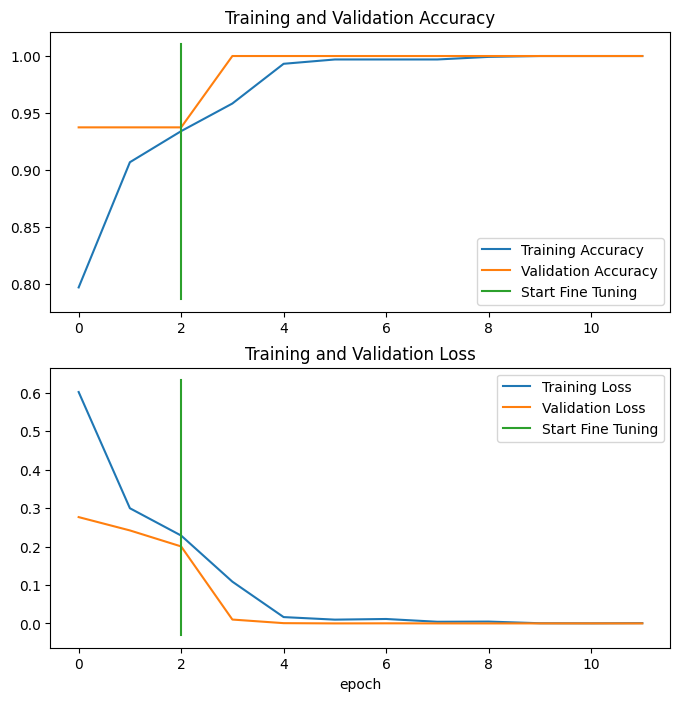

In [ ]:
compare_histories(history_1, history_2, initial_epochs=3)

### 5.5 Calculate Fine-Tuned Model Accuracy and Loss

In [ ]:
loss_1, accuracy_1 = model.evaluate(test_ds)

print(f"Loss on Test Dataset: {loss_1}")
print(f"Accuracy on Test Dataset: {accuracy_1}")

5/5 [==============================] - 6s 225ms/step - loss: 0.2148 - accuracy: 0.9800
Loss on Test Dataset: 0.21484360098838806
Accuracy on Test Dataset: 0.9800000190734863
